In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages',
                     '../src']
sys.prefix = '/home/joaom/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# WITH OVERPASS


In [92]:
import geojson
import requests
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection, shape
from shapely import wkt
from shapely.ops import transform
import shapely
from functools import partial
import pyproj
import time
import json

n_processes = 10

In [178]:
def simplify(s, delta=0.05):
    
    while not check_length(s):
        s = s.simplify(delta, False)
        delta = delta + 0.05

    return s

def check_length(s, threshold=3000):
    
    return len(str(s)) < threshold

def get_area(s):
    s = shape(s)
    proj = partial(pyproj.transform, 
                   pyproj.Proj(init='epsg:4326'),
                   pyproj.Proj(init='epsg:3857'))

    return transform(proj, s).area / 1e6 # km

def threshold_func(g, value):
    
    return get_area(g) < value

def katana(geometry, threshold_func, threshold_value, count=0):
    """Split a Polygon into two parts across it's shortest dimension"""
    bounds = geometry.bounds
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
    if threshold_func(geometry, threshold_value) or count == 250:
        # either the polygon is smaller than the threshold, or the maximum
        # number of recursions has been reached
        return [geometry]
    if height >= width:
        # split left to right
        a = box(bounds[0], bounds[1], bounds[2], bounds[1]+height/2)
        b = box(bounds[0], bounds[1]+height/2, bounds[2], bounds[3])
    else:
        # split top to bottom
        a = box(bounds[0], bounds[1], bounds[0]+width/2, bounds[3])
        b = box(bounds[0]+width/2, bounds[1], bounds[2], bounds[3])
    result = []
    for d in (a, b,):
        c = geometry.intersection(d)
        if not isinstance(c, GeometryCollection):
            c = [c]
        for e in c:
            if isinstance(e, (Polygon, MultiPolygon)):
                result.extend(katana(e, threshold_func, threshold_value, count+1))
    if count > 0:
        return result
    # convert multipart into singlepart
    final_result = []
    for g in result:
        if isinstance(g, MultiPolygon):
            final_result.extend(g)
        else:
            final_result.append(g)
    return final_result




def to_geojson(x, full=False):
    g = geojson.Feature(geometry=x, properties={}).geometry
    if full:
        return g
    if g['type'] == 'MultiPolygon':
        return g['coordinates'][0][0]
    else:
        return g['coordinates'][0]

def swipe(x):
    return [[c[1], c[0]] for c in x]
    
def flatten(l):
    return [str(round(item, 4)) for sublist in l for item in sublist]


def to_overpass_coords(x):
    
    coords = to_geojson(x)
    coords = swipe(coords)
    coords = flatten(coords)
    coords = ' '.join(coords)
    return coords

def overpass_request(s):
    
    print(s['region_slug'])
    print(s['partition'])
    
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
    [out:json];
    way["highway"]["highway"!~"^(construction|cycleway|footway|path|proposed|service|track|pedestrian|living_street|platform|steps)$"]["highway"](poly:"%s");
    for (t["highway"])
    {
       make stat highway=_.val,
           count=count(ways),length=sum(length());
       out;
    }""" % s['overpass_coords']
    
    for i in range(3):
        try:
            response = requests.get(overpass_url, 
                                    params={'data': overpass_query})

            json.dump(response.json(), open(RAW_PATH / 'osm_region_length' / (s['region_slug'] + '_' + str(s['partition'])), 'w'))
            break
        except Exception as e:
            if i == 2:
                print(e)
                print(response.text)
            print('retrying')
            continue
#     return response

In [171]:
url = 'https://docs.google.com/spreadsheets/d/197fccIfjwlsT-oeisHHLn2SuOvbtJjC0inoNuxfqrwI/gviz/tq?tqx=out:csv&sheet=metadata'

metadata = pd.read_csv(url)
metadata = metadata[[c for c in metadata.columns if 'Unnamed' not in c]]

metadata['region_shapefile_wkt'] = metadata['region_shapefile_wkt'].apply(lambda x: wkt.loads(x.replace('"', '')))

# From MultiPolygon to Polygon
metadata['region_shapefile_wkt'] = metadata['region_shapefile_wkt']\
    .apply(lambda x: max(x, key=lambda a: a.area) if isinstance(x, shapely.geometry.multipolygon.MultiPolygon) else x)

# metadata['region_shapefile_wkt'].apply(simplify)

In [172]:
metadata

,country_name,country_iso,region_slug,rerun,region_name,region_type,dashboard,population,timezone,region_shapefile_wkt
0,Argentina,AR,buenosaires,False,Buenos Aires,city,True,14338718.0,America/Argentina/Buenos_Aires,POLYGON ((-58.75041764050466 -34.3670848864218...
1,Argentina,AR,cordoba,False,Córdoba,city,True,1422824.0,America/Argentina/Cordoba,POLYGON ((-64.30875060953629 -31.2754180085397...
2,Argentina,AR,country_argentina,False,Argentina,country,True,45195777.0,NaN,"POLYGON ((-73.560537 -49.942466, -73.438495 -4..."
3,Argentina,AR,mendoza,False,Mendoza,city,True,808809.0,America/Argentina/Mendoza,POLYGON ((-68.83375031296083 -32.8087514466268...
4,Argentina,AR,rosario,False,Rosario,city,True,1018655.0,America/Argentina/Cordoba,POLYGON ((-60.71708417827298 -32.8254181144321...
5,Barbados,BB,bridgetown,False,Bridgetown,city,True,148952.0,America/Barbados,POLYGON ((-59.56666666669878 13.10833333330571...
6,Barbados,BB,country_barbados,False,Barbados,country,True,287371.0,America/Barbados,"POLYGON ((-59.856212 13.308, -59.752251 13.492..."
7,Bolivia,BO,cochabamba,False,Cochabamba,city,False,665851.0,America/La_Paz,POLYGON ((-66.18375048664592 -17.3087503877028...
8,Bolivia,BO,country_bolivia,False,Bolivia,country,True,11673029.0,America/La_Paz,"POLYGON ((-69.64500700000001 -17.281588, -68.7..."
9,Bolivia,BO,lapaz,False,La Paz,city,False,918441.0,America/La_Paz,POLYGON ((-68.16666666669357 -16.4500000000177...


In [173]:
threshold_value = 1000000

In [174]:
def partition_geometry(_df, threshold_value):
    
    geos = katana(_df['region_shapefile_wkt'], threshold_func, threshold_value)

    final = []
    for i, g in enumerate(geos):
        _df['partition'] = i
        _df['shapefile_partition'] = g
        final.append(deepcopy(_df.to_frame().T))

    return pd.concat(final)

In [175]:
metadata_part = pd.DataFrame()
for i, row in metadata.iterrows():
    print(row['region_slug'])
    metadata_part = pd.concat([metadata_part , partition_geometry(row, threshold_value)])

buenosaires
cordoba
country_argentina
mendoza
rosario
bridgetown
country_barbados
cochabamba
country_bolivia
lapaz
santacruzdelasierra
belem
belohorizonte
br_states_acre
br_states_alagoas
br_states_amapa
br_states_amazonas
br_states_bahia
br_states_ceara
br_states_distrito_federal
br_states_espirito_santo
br_states_goias
br_states_maranhao
br_states_mato_grosso
br_states_mato_grosso_do_sul
br_states_minas_gerais
br_states_para
br_states_paraiba
br_states_parana
br_states_pernambuco
br_states_piaui
br_states_rio_de_janeiro
br_states_rio_grande_do_norte
br_states_rio_grande_do_sul
br_states_rondonia
br_states_roraima
br_states_santa_catarina
br_states_sao_paulo
br_states_sergipe
br_states_tocantins
brasilia
campinas
country_brazil
curitiba
florianopolis
fortaleza
goiania
joaopessoa
joinville
maceio
manaus
natal
porto_alergre
recife
riodejaneiro
salvador
santos
saojosedoscampos
saoluis
saopaulo
sorocaba
teresina
vitoria
country_the_bahamas
nassau
belpoman
country_belize
country_chile
sant

In [232]:
metadata_part = metadata_part[metadata_part['region_slug'].isin(missing)]

In [234]:
metadata_part['shapefile_partition'] = metadata_part['shapefile_partition'].apply(simplify)

In [235]:
metadata_part['overpass_coords'] = metadata_part['shapefile_partition'].apply(to_overpass_coords)

In [236]:
rows = [row for i, row in metadata_part.iterrows()]
with Pool(1) as p:
    p.map(overpass_request, rows)

lima_metro2
0
ch_comunas_san_jose_de_maipo
0


In [237]:
regions = set(metadata['region_slug'])

In [238]:
def get_length(j):
    a = pd.DataFrame([r['tags'] for r in j['elements']])
    if len(a):
        return round(a['length'].astype(float).sum(), 2)

paths = (RAW_PATH / 'osm_region_length')
names = [p.name for p in paths.glob('*')]
length = [get_length(json.load(open(s, 'r'))) for s in paths.glob('*')]
length = pd.DataFrame(list(zip(names, length)), columns=['region_slug', 'total_length'])
length['region_slug'] = length['region_slug'].apply(lambda x: '_'.join(x.split('_')[:-1]))
length = length.groupby('region_slug').sum().sort_values(by='total_length')

In [241]:
missing = regions.difference(set(length.index))

In [242]:
missing

set()

In [182]:
!rm -r /home/joaom/projects/waze_coronavirus/data/raw/osm_region_length/.ipynb_checkpoints

In [556]:
# No partition
length.sum()

region_slug     country_argentina_1country_argentina_2country_...
total_length                                          7.46165e+08
dtype: object

In [517]:
# threshold_value = 1000000
length.sum()

region_slug     country_brazil_16country_brazil_4country_brazi...
total_length                                          2.11808e+09
dtype: object

In [549]:
# threshold_value = 100000
length.sum()

region_slug     br_states_rio_de_janeiro_0
total_length                   6.86646e+07
dtype: object

In [275]:
a = set(metadata['region_slug'].unique())

In [285]:
b = set(length.dropna()['region_slug'].unique())

In [288]:
length.dropna().sort_values(by='total_length')

,region_slug,total_length
124,br_states_rio_de_janeiro,1.945152e+04
10,belpoman,1.346914e+05
94,country_argentina,1.385162e+05
78,florianopolis,3.623844e+05
56,georgetown,4.767186e+05
117,santamarta,9.132260e+05
53,sanfernado,9.177647e+05
11,pereira,9.467313e+05
111,nassau,9.592474e+05
60,portofspain,1.008703e+06


In [368]:
geometry = metadata[metadata['region_slug'] == 'country_brazil']['region_shapefile_wkt'].iloc[0]

In [261]:
daily = pd.read_csv('https://bit.ly/idb-traffic-daily')

In [262]:
daily

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,month,day,dow,ratio_20,tcp,Unnamed: 14
0,2020-04-23 13:54:53.813000,salvador,Salvador,Brazil,BR,BR,city,3300883.0,America/Bahia,4,14,2,0.257325,-74.267500,NaN
1,2020-04-23 13:54:53.813000,salvador,Salvador,Brazil,BR,BR,city,3300883.0,America/Bahia,4,7,2,0.285121,-71.487872,NaN
2,2020-04-23 13:54:53.813000,salvador,Salvador,Brazil,BR,BR,city,3300883.0,America/Bahia,3,17,2,0.579930,-42.006959,NaN
3,2020-04-23 13:54:53.813000,salvador,Salvador,Brazil,BR,BR,city,3300883.0,America/Bahia,3,21,6,0.254218,-74.578232,NaN
4,2020-04-23 13:54:53.813000,salvador,Salvador,Brazil,BR,BR,city,3300883.0,America/Bahia,4,18,6,0.433749,-56.625065,NaN
5,2020-04-23 13:54:53.813000,salvador,Salvador,Brazil,BR,BR,city,3300883.0,America/Bahia,4,11,6,0.381004,-61.899595,NaN
6,2020-04-23 13:54:53.813000,salvador,Salvador,Brazil,BR,BR,city,3300883.0,America/Bahia,3,28,6,0.164074,-83.592571,NaN
7,2020-04-23 13:54:53.813000,salvador,Salvador,Brazil,BR,BR,city,3300883.0,America/Bahia,3,14,6,0.979490,-2.050974,NaN
8,2020-04-23 13:54:53.813000,salvador,Salvador,Brazil,BR,BR,city,3300883.0,America/Bahia,4,4,6,0.232165,-76.783474,NaN
9,2020-04-23 13:54:53.813000,br_states_para,Para,Brazil,BR,BR,state,NaN,NaN,3,19,4,0.837629,-16.237090,NaN


In [415]:
import folium

In [416]:
m = folium.Map(zoom_start=1, tiles='cartodbpositron')
for i in a:
    m.add_children(folium.GeoJson(i))
m

In [499]:
paths = (RAW_PATH / 'osm_region_length')
names = [p.name for p in paths.glob('country_brazil_*')]

In [250]:
pd.DataFrame([], columns=['region_shapefile_wkt'])

,region_shapefile_wkt


In [244]:
import osm_road_length

In [248]:
a = metadata['region_shapefile_wkt'].iloc[0]

In [259]:
import pyarrow

[autoreload of pyarrow._generated_version failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.7/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 160, in reload
    name=parent_name) from None
ImportError: parent 'pyarrow' not in sys.modules
]
[autoreload of pyarrow.compat failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/opt/conda/lib

AttributeError: type object 'pyarrow.lib.Message' has no attribute '__reduce_cython__'

In [260]:
import awswrangler as wr

AttributeError: type object 'pyarrow.lib.Message' has no attribute '__reduce_cython__'

In [ ]:
 wr.s3.to_parquet(
    df=pd.DataFrame({
        'col': [1, 2, 3],
        'col2': ['A', 'A', 'B']
    }),
    path='s3://bucket/prefix',
    dataset=True,
    partition_cols=['col2']
)

In [263]:
import geobr

In [275]:
year = 2010
types = {
    'States': geobr.read_state(code_state='all', year=year),
    'Meso Regions': geobr.read_meso_region(code_meso="all", year=year),
    'Micro Regions': geobr.read_micro_region(code_micro='all', year=2017),
    'Municipalities': geobr.read_municipality(code_muni='all', year=year)
}

In [271]:
brasilio = pd.read_csv('https://data.brasil.io/dataset/covid19/caso.csv.gz')

In [274]:
last = brasilio[brasilio['is_last']]

In [277]:
last.head(1)

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-04-22,SE,NaN,state,118,7,30,True,2298696.0,28.0,5.13335,0.0593


In [278]:
df.merge(last, left_on='code_muni', right_on='city_ibge_code')

,code_muni,name_muni,code_state,abbrev_state,geometry,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,1100023.0,Ariquemes,11,RO,POLYGON ((-63.13712041193418 -9.78412882855439...,2020-04-21,RO,Ariquemes,city,39,0,11,True,107863.0,1100023.0,36.15698,NaN
1,1100114.0,Jaru,11,RO,POLYGON ((-62.33904747331758 -10.3068598886385...,2020-04-21,RO,Jaru,city,1,0,22,True,51775.0,1100114.0,1.93143,NaN
2,1100122.0,Ji-Paraná,11,RO,POLYGON ((-61.66205501414029 -9.71251582769541...,2020-04-21,RO,Ji-Paraná,city,7,2,31,True,128969.0,1100122.0,5.42766,0.2857
3,1100155.0,Ouro Preto Do Oeste,11,RO,POLYGON ((-62.10052368859817 -10.6591578078131...,2020-04-21,RO,Ouro Preto do Oeste,city,6,0,13,True,36035.0,1100155.0,16.65048,NaN
4,1100189.0,Pimenta Bueno,11,RO,POLYGON ((-60.53924691286519 -11.5419253240156...,2020-04-21,RO,Pimenta Bueno,city,1,0,1,True,36660.0,1100189.0,2.72777,NaN
5,1100205.0,Porto Velho,11,RO,POLYGON ((-63.93601297670062 -8.59285766863859...,2020-04-21,RO,Porto Velho,city,163,3,30,True,529544.0,1100205.0,30.78120,0.0184
6,1100288.0,Rolim De Moura,11,RO,POLYGON ((-61.61300261562807 -11.5838356785665...,2020-04-21,RO,Rolim de Moura,city,3,0,16,True,55058.0,1100288.0,5.44880,NaN
7,1100304.0,Vilhena,11,RO,POLYGON ((-60.30097691000801 -12.2534786916916...,2020-04-21,RO,Vilhena,city,1,0,16,True,99854.0,1100304.0,1.00146,NaN
8,1100403.0,Alto Paraíso,11,RO,POLYGON ((-63.10926657721378 -9.75322504161748...,2020-04-21,RO,Alto Paraíso,city,1,0,4,True,21428.0,1100403.0,4.66679,NaN
9,1100452.0,Buritis,11,RO,"POLYGON ((-64.228476199708 -10.15056136695087,...",2020-04-21,RO,Buritis,city,1,0,6,True,39654.0,1100452.0,2.52181,NaN


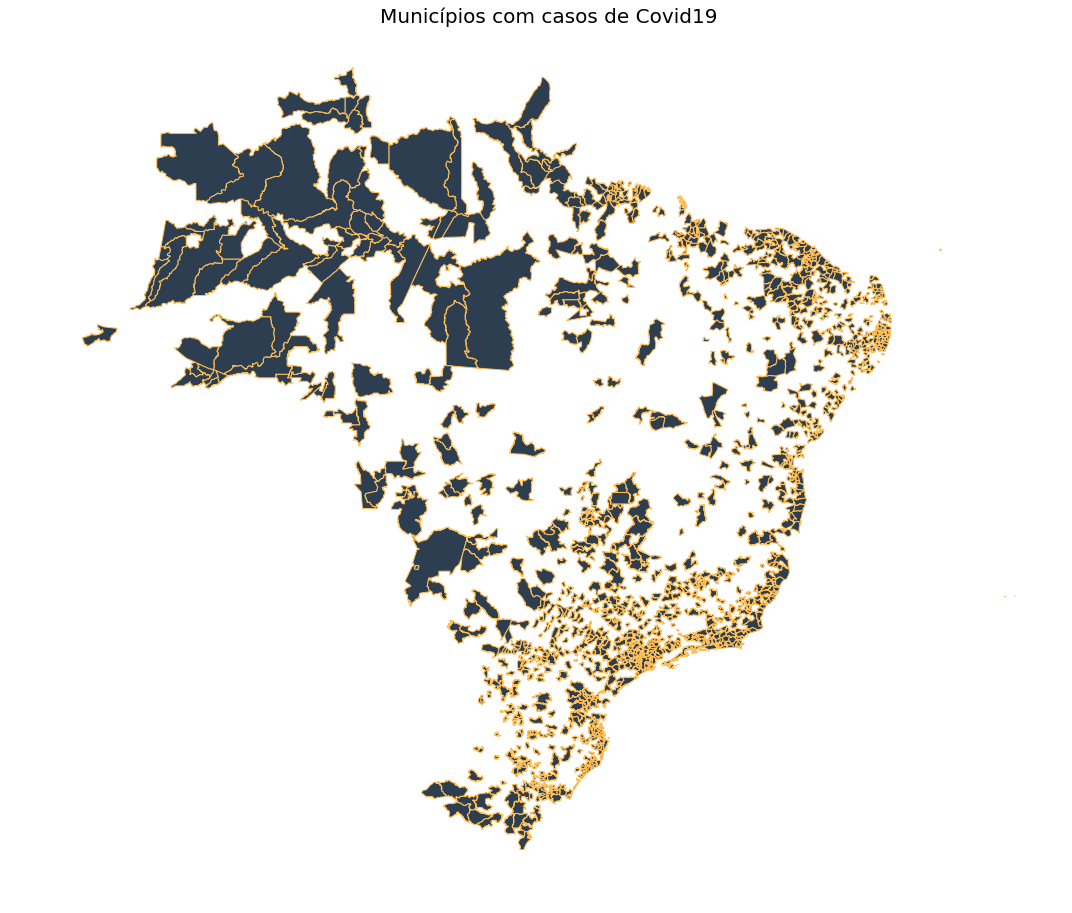

In [282]:
fig, axis = plt.subplots(nrows=1, ncols=1,
                      figsize=(15, 15))

df.merge(last, left_on='code_muni', right_on='city_ibge_code')\
.plot(facecolor='#2D3E50', edgecolor='#FEBF57', ax=axis)
        
axis.set_title("Municípios com casos de Covid19", fontsize=20)
axis.axis('off')

fig.tight_layout()

In [ ]:
nrows = 2
ncols = 2
fontsize = 20

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                      figsize=(15, 15), dpi=300)

types_iter = iter(types.items())

for r in range(nrows):
    for c in range(ncols):
        
        axis = ax[r][c]
        name, df = next(types_iter)
        
        df.plot(facecolor='#2D3E50', edgecolor='#FEBF57', ax=axis)
        
        axis.set_title(name, fontsize=fontsize)
        axis.axis('off')

# General
fig.tight_layout()
fig.savefig(f'imgs/1.geobr_logo.png')